In [14]:
import sys
sys.path.append("/Users/jameskitchens/Documents/GitHub/sparg2.0")

import sparg
import tskit
import msprime
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("always")

In [15]:
ts = tskit.load("two_pops.trees")

np.random.seed(1)
samples = list(np.random.choice(ts.samples(), 100, replace=False))
ts_sim, map_sim = ts.simplify(samples=samples, map_nodes=True, keep_input_roots=False, keep_unary=True, update_sample_flags=False)

In [16]:
ts_small, maps_small = sparg.simplify_with_recombination(ts=ts_sim, flag_recomb=True)

location_x = []
composition = []

subpop_and_seq_len = {sample:{ subpop:0 for subpop in range(2)} for sample in ts_small.samples()}

for tree in ts_small.trees():
    for root in tree.roots:
        if ts_small.individual(ts_small.node(root).individual).location[0] < 50:
            subpop = 0
        else:
            subpop = 1
        for sample in tree.samples(root):
            subpop_and_seq_len[sample][subpop] += tree.span

for sample in subpop_and_seq_len:
    location_x.append(ts_small.individual(ts_small.node(sample).individual).location[0])
    composition.append(subpop_and_seq_len[sample][1] / sum(subpop_and_seq_len[sample].values()))

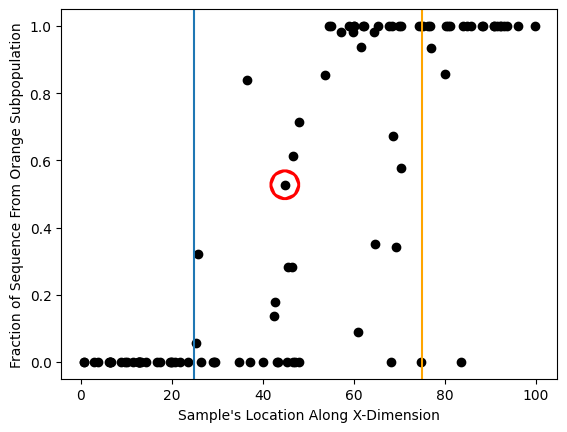

In [17]:
plt.scatter(location_x, composition, color="black")
plt.scatter(location_x[41], composition[41], color="none", edgecolors="red", linewidth=20, s=5)
plt.axvline(x = 25, label = "Starting Location of Blue Subpopulation")
plt.axvline(x = 75, color = "orange", label = "Starting Location of Orange Subpopulation")
plt.xlabel("Sample's Location Along X-Dimension")
plt.ylabel("Fraction of Sequence From Orange Subpopulation")
plt.savefig("two_pops_composition.svg")
plt.show()

In [18]:
output = sparg.estimate_spatial_parameters(ts=ts_small, verbose=True)

Prepared input parameters - Section Elapsed Time: 0.002172231674194336 - Total Elapsed Time: 0.0021779537200927734


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1886/1886 [00:01<00:00, 1521.16it/s]


Calculated covariance matrix - Section Elapsed Time: 1.2448241710662842 - Total Elapsed Time: 1.2475712299346924
Inverted covariance matrix - Section Elapsed Time: 0.0660240650177002 - Total Elapsed Time: 1.3137409687042236
Created root locations vector - Section Elapsed Time: 0.7887611389160156 - Total Elapsed Time: 2.1025290489196777
Estimated dispersal rate - Section Elapsed Time: 0.0003211498260498047 - Total Elapsed Time: 2.1029841899871826


In [19]:
locations_df = sparg.create_ancestors_dataframe(ts=ts_sim, samples=[41], include_locations=True)
locations_df = pd.concat([locations_df, locations_df.apply(sparg.estimate_location, axis=1, ts=ts_small, spatial_parameters=output)], axis=1)

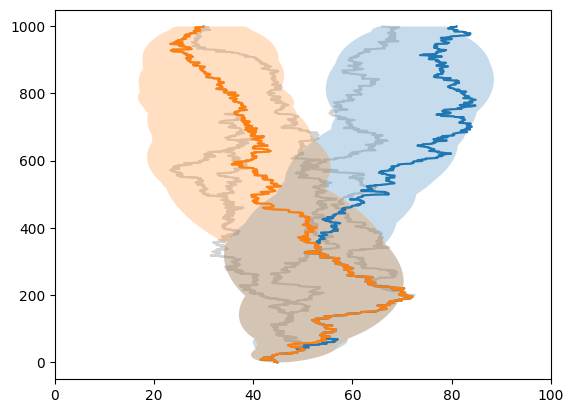

In [20]:
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        left = []
        right = []
        # Fix this eventually
        for i,row in region.iterrows():
            left.append(row["estimated_location_0"]-1.96*math.sqrt(round(row["variance_in_estimated_location_0"],3)))
            right.append(row["estimated_location_0"]+1.96*math.sqrt(round(row["variance_in_estimated_location_0"],3)))
        plt.fill_betweenx(
            y=region["time"],
            x1=left,
            x2=right,
            alpha=0.25,
            label="estimated"
        )
for i,region in locations_df.groupby(["sample", "interval_left"]):
    plt.plot(region["true_location_0"], region["time"], color="lightgray", zorder=0)
    
for i,region in locations_df.groupby(["sample", "interval_left"]):
    if i == (41, 0.0) or i == (41, 697443.0):
        plt.plot(region["true_location_0"], region["time"])
plt.xlim(0,100)
plt.savefig("two_pops_genetic_ancestors.svg")
plt.show()